In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import operator
import numpy as np

from ctapipe.io import TableLoader

import astropy.units as u
from astropy.table import vstack, QTable
from astropy.coordinates.angle_utilities import angular_separation
from astropy.coordinates.angle_utilities import angular_separation

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.metrics import roc_auc_score, roc_curve

from pyirf.simulations import SimulatedEventsInfo
from pyirf.benchmarks import energy_bias_resolution, angular_resolution
from pyirf.cuts import evaluate_binned_cut, calculate_percentile_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.spectral import (
    CRAB_HEGRA, PowerLaw, POINT_SOURCE_FLUX_UNIT, calculate_event_weights, IRFDOC_PROTON_SPECTRUM,
    CRAB_MAGIC_JHEAP2015
)
from pyirf.utils import cone_solid_angle
from pyirf.binning import create_bins_per_decade, create_histogram_table
from pyirf.irf import effective_area_per_energy_and_fov
from pyirf.cut_optimization import optimize_gh_cut

%matplotlib widget

In [3]:
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
obstime = 50 * u.hour
fov_offset_min = 0 * u.deg
fov_offset_max = 1 * u.deg

alpha = 0.2
sensitivity_bins = create_bins_per_decade(10 * u.GeV, 100 * u.TeV)

In [5]:
opts = dict(load_dl2=True, load_simulated=True, load_dl1_parameters=False)


particles = {
    "gammas": {"path": './build/gamma-diffuse_eval.dl2.h5', 'target_spectrum': CRAB_HEGRA},
    "protons": {"path": './build/proton_eval.dl2.h5', 'target_spectrum': IRFDOC_PROTON_SPECTRUM},
}


for name, p in particles.items():
    print(f"Reading {name}")
    with TableLoader(p['path'], **opts) as g_loader:
        
        p['events'] = QTable(g_loader.read_subarray_events(), copy=False)
        
        p['simulation_configuration'] = g_loader.read_simulation_configuration()
        p['shower_distribution'] = g_loader.read_shower_distribution()
        p['simulated_events'] = SimulatedEventsInfo(
            n_showers=p['shower_distribution']['histogram'].sum(),
            energy_min=p['simulation_configuration']['energy_range_min'].quantity[0],
            energy_max=p['simulation_configuration']['energy_range_max'].quantity[0],
            max_impact=p['simulation_configuration']['max_scatter_range'].quantity[0],
            spectral_index=p['simulation_configuration']['spectral_index'][0],
            viewcone=p['simulation_configuration']['max_viewcone_radius'].quantity[0],
        )
        p['simulated_spectrum'] =  PowerLaw.from_simulation(p['simulated_events'], obstime=obstime)
        
        # renames to "select" algorithm
        p["events"]["reco_energy"] = p["events"]["RandomForestRegressor_energy"]
        p["events"]["reco_alt"] = p["events"]["HillasReconstructor_alt"]
        p["events"]["reco_az"] = p["events"]["HillasReconstructor_az"]
        p["events"]["gh_score"] = p["events"]["RandomForestClassifier_prediction"]
        
        # derive some columns
        p["events"]["theta"] = angular_separation(
            p["events"]["HillasReconstructor_az"], p["events"]["HillasReconstructor_alt"],
            p["events"]["true_az"], p["events"]["true_alt"],
        )
        
        p["events"]['true_source_fov_offset'] = angular_separation(
            p["events"]["true_az"], p["events"]["true_alt"],
            0 * u.deg, 70 * u.deg,
        )
        
        p['events']['valid_dl2'] = (
            p['events']['HillasReconstructor_is_valid']
            & p['events']['RandomForestRegressor_is_valid']
            & p['events']['RandomForestClassifier_is_valid']
        )
        

        if name == 'gammas':
            # integrate in fov_offset min / max and select events
            p['events']['selected_fov'] = (
                (p['events']['true_source_fov_offset'] >= fov_offset_min)
                & (p['events']['true_source_fov_offset'] < fov_offset_max)
            )
                     
            p['simulated_spectrum_original'] = p['simulated_spectrum']
            p['simulated_spectrum'] = p['simulated_spectrum'].integrate_cone(fov_offset_min, fov_offset_max)
            

        p["events"]["weight"] =  calculate_event_weights(
            p["events"]["true_energy"],
            target_spectrum=p["target_spectrum"], 
            simulated_spectrum=p["simulated_spectrum"]
        )

        p["events"]["reco_source_fov_offset"] = angular_separation(
            p["events"]["reco_az"], p["events"]["reco_alt"],
            0 * u.deg, 70 * u.deg,
        )    
        
    print('done')

Reading gammas
done
Reading protons
done


In [6]:
events = vstack([p["events"] for p in particles.values()])
gammas = particles['gammas']['events']
protons = particles['protons']['events']

## Gammaness Distributions

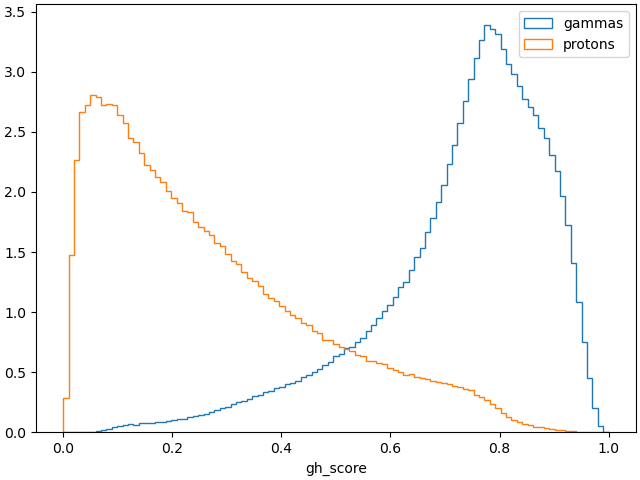

In [7]:
fig, ax = plt.subplots()

hist_opts = dict(bins=101, range=[0, 1], histtype='step', density=True)

key = "gh_score"
for label, t in particles.items():
    valid = t['events']['valid_dl2']
    plt.hist(t['events'][key][valid], **hist_opts, label=label)

ax.set_xlabel(key)
ax.legend()

Text(0.5, 0, 'gammaness')

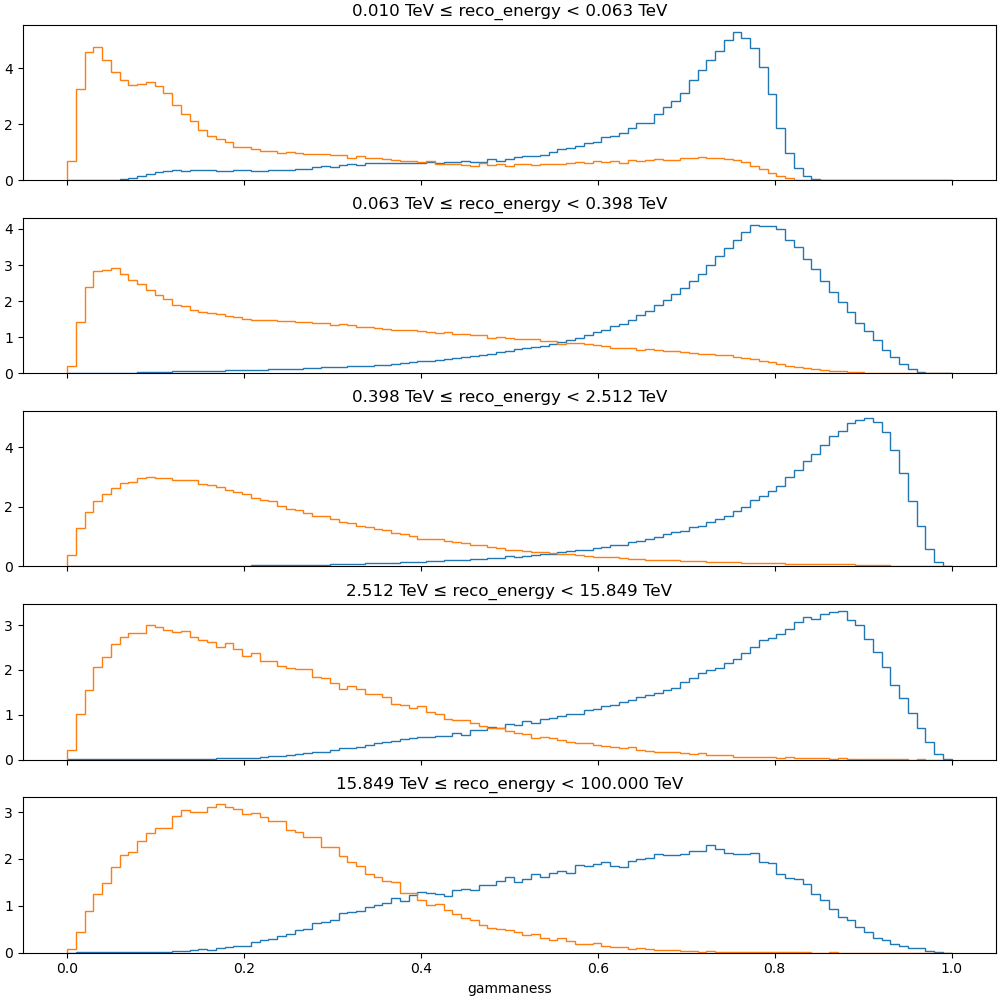

In [8]:
n_bins = 5
reco_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)


fig, axs = plt.subplots(
    len(reco_energy_bins) - 1, 1,
    figsize=(10, 2 * n_bins),
    sharex=True,
)

hist_opts = dict(bins=101, range=[0, 1], histtype='step', density=True)

key = "gh_score"

for label, p in particles.items():
    
    grouped = p['events'].group_by(np.digitize(p['events']['reco_energy'], reco_energy_bins))
    
    for idx, group  in zip(grouped.groups.keys, grouped.groups):
        # skip under / overflow
        if idx == 0 or idx == (n_bins + 1):
            continue
        
        idx -= 1
        ax = axs[idx]
        
        valid = group['valid_dl2']
        ax.hist(group[key][valid], **hist_opts, label=label)
        ax.set_title('{:.3f} ≤ reco_energy < {:.3f}'.format(reco_energy_bins[idx], reco_energy_bins[idx + 1]))
            
axs[-1].set_xlabel('gammaness')

## ROC-Curve

[Text(0.5, 1.0, 'ROC AUC: 0.944'), None, (-0.01, 1.01), (-0.01, 1.01)]

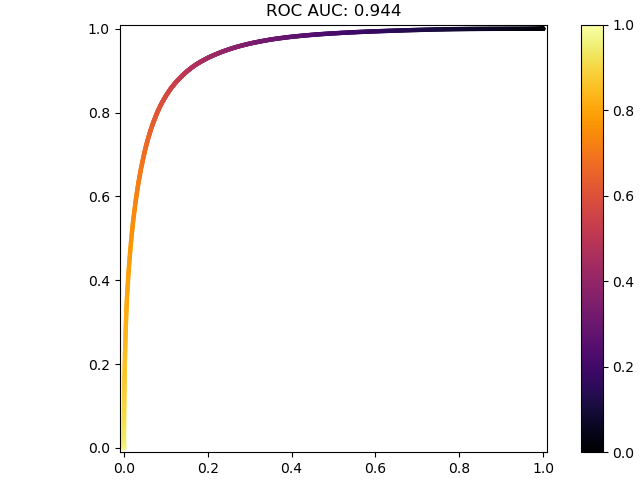

In [9]:
mask = events['valid_dl2']
fpr, tpr, threshold = roc_curve(
    events['true_shower_primary_id'][mask],
    # sklearn computes confusion matrix for each possible cut
    # much faster if rounded to 3 digits to reduce number of unique values
    np.round(events['RandomForestClassifier_prediction'][mask], 3), 
    pos_label=0,
)

roc_auc = np.trapz(x=fpr, y=tpr)


fig, ax = plt.subplots()

plot = ax.scatter(
    fpr, tpr,
    c=threshold,
    cmap='inferno',
    vmin=0,
    vmax=1,
    s=5,
)

fig.colorbar(plot, ax=ax)

ax.set(
    title=f'ROC AUC: {roc_auc:.3f}',
    aspect=1,
    xlim=(-0.01, 1.01),
    ylim=(-0.01, 1.01),
)

In [10]:
n_bins = 10
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)

bin_index = np.digitize(events['reco_energy'].to_value(u.TeV), bins.to_value(u.TeV))
grouped = events.group_by(bin_index)

roc_curves = []
roc_aucs = np.full(n_bins, np.nan)
for idx, group  in zip(grouped.groups.keys, grouped.groups):
    
    # ignore under / overflow
    if idx == 0 or idx == n_bins + 1:
        continue
        
    mask = group["RandomForestClassifier_is_valid"]
    fpr, tpr, threshold = roc_curve(
        group['true_shower_primary_id'][mask],
        np.round(group['RandomForestClassifier_prediction'][mask], 3), 
        pos_label=0,
    )

    roc_curves.append((fpr, tpr, threshold))
    roc_aucs[idx - 1] = np.trapz(y=tpr, x=fpr)

[None, (0.0, 1.01), Text(0, 0.5, 'ROC Auc'), Text(0.5, 0, 'reco_energy / GeV')]

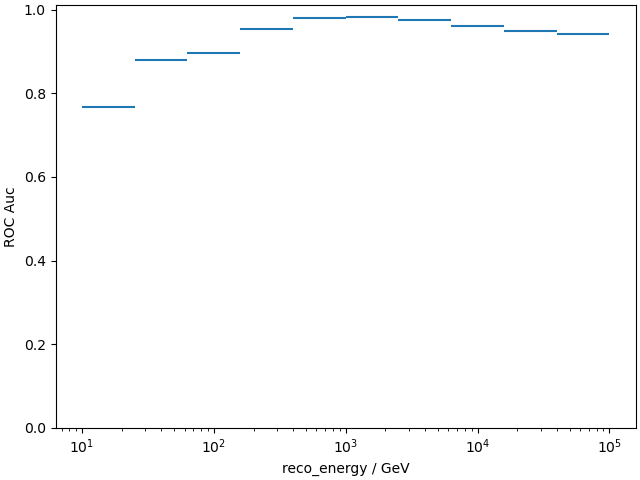

In [11]:
fig, ax = plt.subplots()

center = 0.5 * (bins[1:] + bins[:-1])
width = 0.5 * np.diff(bins) 

ax.errorbar(
    center.to_value(u.GeV),
    roc_aucs,
    xerr=width.to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
    ylim=(0, 1.01),
    ylabel='ROC Auc',
    xlabel='reco_energy / GeV'
)

Text(0.5, 1.0, 'Initial Gammaness-Cut (40.0% efficiency)')

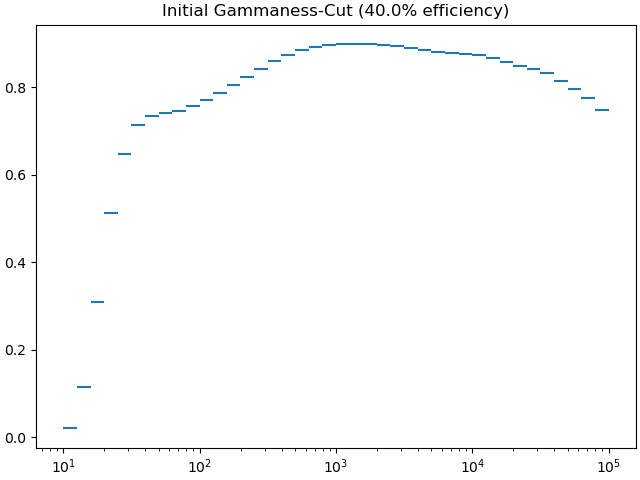

In [12]:
n_bins = 40
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)


initial_gh_cut_efficiency = 0.4

selection = gammas['valid_dl2'] & gammas['selected_fov']


initial_gh_cuts = calculate_percentile_cut(
    gammas['gh_score'][selection],
    gammas['reco_energy'][selection],
    bins=bins,
    fill_value=0.0,
    percentile=100 * (1 - initial_gh_cut_efficiency),
    min_events=25,
    smoothing=1,
)


fig, ax = plt.subplots()

ax.errorbar(
    initial_gh_cuts['center'].to_value(u.GeV),
    initial_gh_cuts['cut'],
    xerr=0.5 * (initial_gh_cuts['high'] - initial_gh_cuts['low']).to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
)
ax.set_title(f'Initial Gammaness-Cut ({initial_gh_cut_efficiency:.1%} efficiency)')

In [13]:
n_bins = 40
bins = np.geomspace(10 * u.GeV, 100 * u.TeV, n_bins + 1)

initial_gh_mask = evaluate_binned_cut(
    gammas["gh_score"],
    gammas["reco_energy"],
    initial_gh_cuts,
    op=operator.gt,
)


theta_cuts = calculate_percentile_cut(
    gammas['theta'][selection & initial_gh_mask].to(u.deg),
    gammas['reco_energy'][selection & initial_gh_mask],
    bins=bins,
    fill_value=0.3 * u.deg,
    max_value=0.3 * u.deg,
    percentile=68,
    min_events=100,
    smoothing=1.5,
)

theta_mask = evaluate_binned_cut(
    gammas['theta'],
    gammas['reco_energy'],
    theta_cuts,
    op=operator.lt,
)


for col in ('low', 'high', 'center', 'cut'):
    theta_cuts[col].info.format = '.4f'

theta_cuts

low,high,center,n_events,cut
TeV,TeV,TeV,,deg
float64,float64,float64,int64,float64
0.0100,0.0126,0.0113,0,0.3000
0.0126,0.0158,0.0142,0,0.3000
0.0158,0.0200,0.0179,52,0.3000
0.0200,0.0251,0.0225,844,0.3000
0.0251,0.0316,0.0284,2701,0.2997
0.0316,0.0398,0.0357,4189,0.2981
0.0398,0.0501,0.0450,3911,0.2928
0.0501,0.0631,0.0566,3985,0.2797


Text(0.5, 1.0, 'Theta-Cut (68% efficiency)')

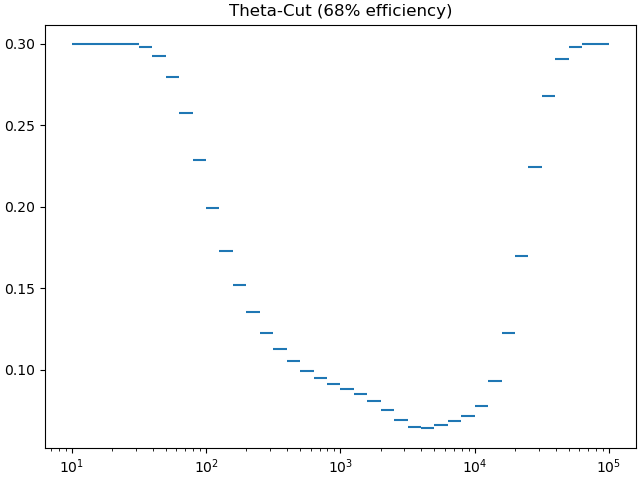

In [14]:
fig, ax = plt.subplots()

ax.errorbar(
    theta_cuts['center'].to_value(u.GeV),
    theta_cuts['cut'].to_value(u.deg),
    xerr=0.5 * (theta_cuts['high'] - theta_cuts['low']).to_value(u.GeV),
    ls='',
)

ax.set(
    xscale='log',
)
ax.set_title('Theta-Cut (68% efficiency)')

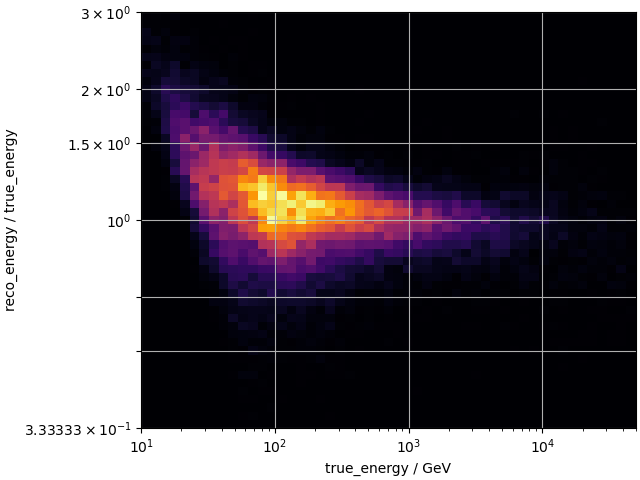

In [15]:
e_bins = np.geomspace(10 * u.GeV, 50 * u.TeV, 52)
mu_bins = np.geomspace(1/3, 3, 52)

fig, ax = plt.subplots(constrained_layout=True)

mask = selection & initial_gh_mask & theta_mask

gammas = particles["gammas"]["events"]
ax.hist2d(
    gammas['true_energy'][mask].to_value(u.GeV),
    (gammas['reco_energy'][mask] / gammas['true_energy'][mask]).to_value(u.one),
    bins=[e_bins.to_value(u.GeV), mu_bins],
    cmap='inferno',
)


ax.grid()
ax.set(
    xscale='log',
    yscale='log',
    xlabel='true_energy / GeV',
    ylabel='reco_energy / true_energy',
)
ax.set_yticks(np.array([1/3, 1/2, 2/3, 1.0, 3/2, 2/1, 3/1]))
ax.set_yticks([], minor=True)
None

In [16]:
mask = (
    selection
    & theta_mask
    & initial_gh_mask
)

np.count_nonzero([selection[selection], theta_mask[selection], initial_gh_mask[selection], mask[selection]], axis=1)

array([135757,  78505,  55885,  36527])

In [17]:
true_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, 21)

bias_resolution = QTable(energy_bias_resolution(
    gammas[mask],
    true_energy_bins,
    bias_function=np.mean
))

In [18]:
bias_resolution

true_energy_low,true_energy_high,true_energy_center,n_events,bias,resolution
TeV,TeV,TeV,,,
float64,float64,float64,int64,float64,float64
0.01,0.015848931924611134,0.012924465962305568,349,1.0393884450941708,0.36075481564370104
0.015848931924611134,0.025118864315095794,0.020483898119853464,1600,0.5774048435477375,0.30975242978250994
0.025118864315095794,0.039810717055349734,0.03246479068522276,3423,0.29246174859023083,0.2782243590784084
0.039810717055349734,0.06309573444801933,0.05145322575168453,4533,0.16363162693573813,0.2679111156542909
0.06309573444801933,0.1,0.08154786722400967,5342,0.09175197175598167,0.2090991290856452
0.1,0.15848931924611143,0.1292446596230557,5059,0.03441001151782637,0.18798171357612656
0.15848931924611143,0.25118864315095807,0.20483898119853475,4203,0.02813914332223276,0.16983860346154905
0.25118864315095807,0.3981071705534973,0.32464790685222766,3178,0.018844495164760926,0.14506743998070162


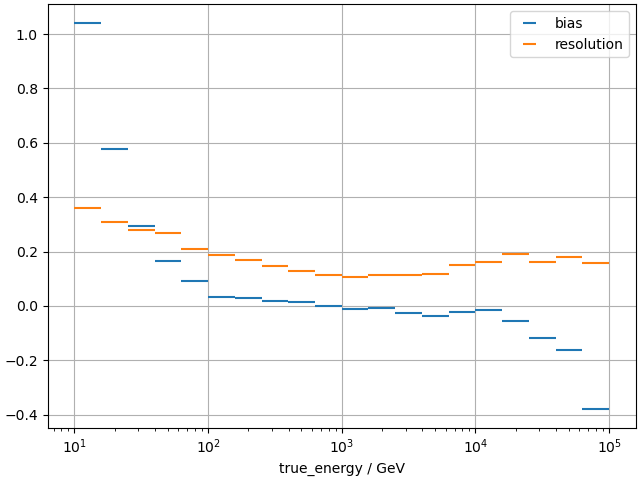

In [19]:
fig, ax = plt.subplots()


for key in ("bias", "resolution"):
    ax.errorbar(
        bias_resolution["true_energy_center"].to_value(u.GeV),
        bias_resolution[key],
        xerr=(bias_resolution["true_energy_high"] - bias_resolution["true_energy_low"]).to_value(u.GeV) / 2,
        ls='',
        label=key
    )

ax.set(
    xscale='log',
    xlabel='true_energy / GeV',
)
ax.legend()
ax.grid()

## Angular Resolution

In [20]:

bins = create_bins_per_decade(10 * u.GeV, 101 * u.TeV, 5)


fov_bins = [0, 1, 2, 3] * u.deg

resolutions = []
for inner, outer in zip(fov_bins[0:-1], fov_bins[1:]):
    
    selection = (
        gammas['valid_dl2'] 
        & (gammas['true_source_fov_offset'] >= inner)
        & (gammas['true_source_fov_offset'] < outer)
        & (initial_gh_mask)
    )

    resolutions.append(QTable(angular_resolution(
        gammas[selection],
        energy_bins=bins,
    )))

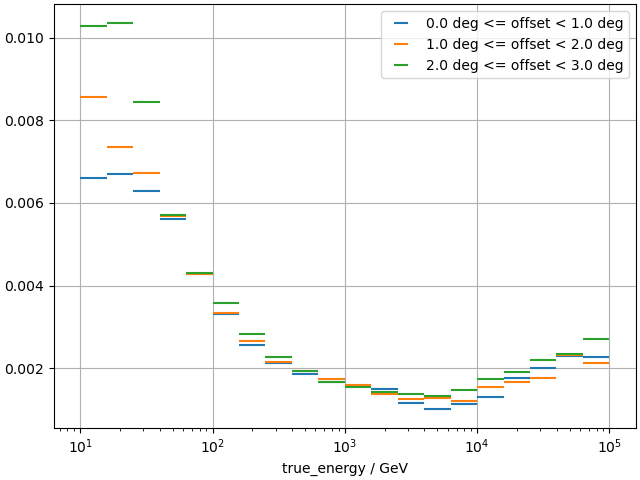

In [21]:
fig, ax = plt.subplots()


for ang_res, inner, outer in zip(resolutions, fov_bins[0:-1], fov_bins[1:]):

    ax.errorbar(
        ang_res["true_energy_center"].to_value(u.GeV),
        ang_res["angular_resolution"],
        xerr=(ang_res["true_energy_high"] - ang_res["true_energy_low"]).to_value(u.GeV) / 2,
        ls='',
        label=f'{inner} <= offset < {outer}'
    )

ax.set(
    xscale='log',
    xlabel='true_energy / GeV',
)
ax.legend()
ax.grid()

## Sensivitity

In [22]:
for k, p in particles.items():
    p["events"]["selected_gh"] = evaluate_binned_cut(
        p["events"]["gh_score"],
        p["events"]["reco_energy"],
        initial_gh_cuts,
        op=operator.gt,
    )
    

In [23]:
np.seterr(invalid="ignore")

selected_offset = (
    (particles['gammas']["events"]["true_source_fov_offset"] >= fov_offset_min)
    & (particles['gammas']["events"]["true_source_fov_offset"] < fov_offset_max)
)

sensitivity, best_gh_cuts = optimize_gh_cut(
    signal=particles['gammas']['events'][selected_offset],
    background=particles['protons']['events'],
    reco_energy_bins=bins,
    gh_cut_efficiencies=np.arange(0.3, 0.95, 0.05),
    theta_cuts=theta_cuts,
    alpha=alpha,
    fov_offset_min=fov_offset_min,
    fov_offset_max=fov_offset_max,
)
sensitivity['flux'] = sensitivity['relative_sensitivity'] * CRAB_HEGRA(sensitivity['reco_energy_center'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.30it/s]


In [24]:
magic_sensitivity = QTable.read('./magic_sensitivity_2014.ecsv')
magic_sensitivity['flux'] = magic_sensitivity['sensitivity_lima_5off']
magic_sensitivity['reco_energy_center'] = 0.5 * (magic_sensitivity['e_max'] + magic_sensitivity['e_min'])
magic_sensitivity['reco_energy_low'] = magic_sensitivity['e_min']
magic_sensitivity['reco_energy_high'] = magic_sensitivity['e_max']

In [25]:
cta_requirement = QTable.read('./cta_requirements_North-50h.dat', format="ascii.basic")

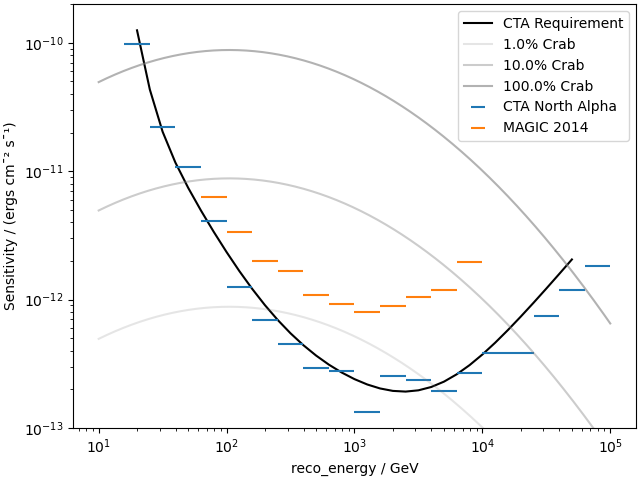

In [26]:
unit = (u.erg / u.cm**2 / u.s)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(cta_requirement['reco_energy'] * 1e3, cta_requirement['flux'], color='k', label='CTA Requirement')

for s, label in zip((sensitivity, magic_sensitivity), ("CTA North Alpha", "MAGIC 2014")):

    ax.errorbar(
        s['reco_energy_center'].to_value(u.GeV),
        (s['reco_energy_center']**2 * s['flux']).to_value(unit),
        xerr=0.5 * (s['reco_energy_high'] - s['reco_energy_low']).to_value(u.GeV),
        ls='',
        label=label,
    )

e = np.geomspace(10 * u.GeV, 100 * u.TeV, 500)

for crab, alpha in zip((0.01, 0.1, 1), (0.2, 0.4, 0.6)):
    ax.plot(e.to_value(u.GeV), crab * (e**2 * CRAB_MAGIC_JHEAP2015(e)).to_value(unit), color='gray', alpha=alpha, label=f'{crab:.1%} Crab')


ax.legend()
ax.set(
    xscale='log',
    xlabel='reco_energy / GeV',
    ylabel='Sensitivity / (ergs cm¯² s¯¹)',
    ylim=(1e-13, 2e-10)
)
ax.set_yscale('log')

In [27]:
true_energy_bins = np.geomspace(10 * u.GeV, 100 * u.TeV, 26)

for name, p in particles.items():
    p['effective_areas'] = {}
    
    table = p['events']
    
    valid_mask = table['valid_dl2']
    prediction_mask = evaluate_binned_cut(
        table["gh_score"],
        table["reco_energy"],
        best_gh_cuts,
        op=operator.gt,
    )

    cut_mask = (
        valid_mask
        & prediction_mask
    )

    if name == 'gammas':
        theta_mask = evaluate_binned_cut(
            table["theta"],
            table["reco_energy"],
            theta_cuts,
            op=operator.lt,
        )
        cut_mask &= theta_mask


    
    masks = {
        'At Trigger': slice(None),
        'At DL2': valid_mask,
        f'After θ and gammaness cut' if name == 'gammas' else 'After gammaness cut': cut_mask,
        
    }

    for label, selection in masks.items():
        
        p['effective_areas'][label] = effective_area_per_energy_and_fov(
            table[selection],
            p["simulated_events"],
            true_energy_bins=true_energy_bins,
            fov_offset_bins=[0, 2] * u.deg,
        )[:, 0]

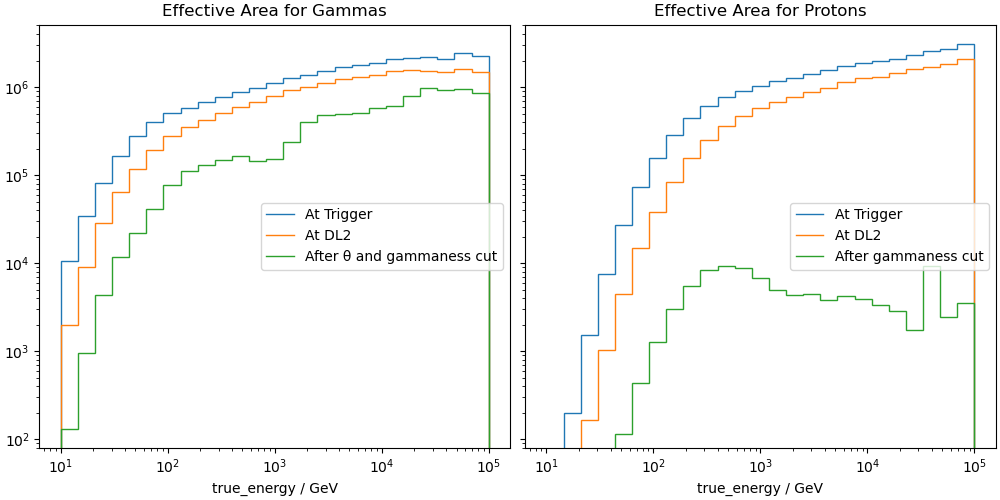

In [28]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, sharey=True, figsize=(10, 5))

for ax, (name, p) in zip(axs, particles.items()):
        
    ax.set_title(f'Effective Area for {name.title()}')
    
    for label, area in p['effective_areas'].items():
        ax.stairs(area.to_value(u.m**2), true_energy_bins.to_value(u.GeV), label=label)
        
    ax.legend(loc='center right')

    ax.set(
        xscale='log',
        yscale='log',
        xlabel='true_energy / GeV'
    )